# Import necessary libraries

In [120]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Get the data

In [121]:
# Create transformer that makes tensors
transforms = transforms.Compose([transforms.ToTensor()])

#Load our dataset
train_dataset = datasets.MNIST(root = './data', 
                            train = True, 
                            transform = transforms,
                            download = True)

test_dataset = datasets.MNIST(root = './data', 
                            train = False, 
                            transform = transforms)

# Visualizing the data


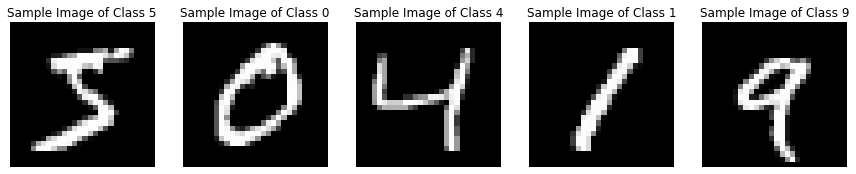

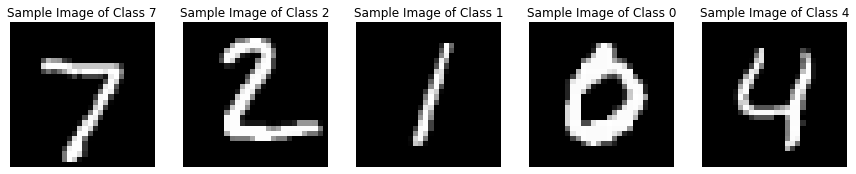

In [129]:
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title('Sample Image of Class {}'.format(train_dataset[i][1]))
    plt.imshow(train_dataset[i][0].reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.show()
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title('Sample Image of Class {}'.format(test_dataset[i][1]))
    plt.imshow(test_dataset[i][0].reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.show()

In [123]:
batch_size = 64
#Make the dataset iterable
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)

# Build the model

In [124]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # input is 28 x 28
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        # output per channel is 28x28
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # output per channel is 14x14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        # another maxpool here
        # output per channel is 7x7 for 32 channels
        # 7x7x64 = 3136
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(-1,1568)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

# Train the model

In [125]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()    
loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


num_epochs = 5

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()         
    
    for i, (inputs, labels) in enumerate(train_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.item()         # Accumulate the loss
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Validation
    testing_loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the validation loss
    test_loss.append(testing_loss/iterations)
    # Record the validation accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Validation Loss: {:.3f}, Validation Accuracy: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Epoch 1/5, Training Loss: 0.364, Training Accuracy: 90.120, Testing Loss: 0.118, Testing Acc: 96.480
Epoch 2/5, Training Loss: 0.126, Training Accuracy: 96.320, Testing Loss: 0.079, Testing Acc: 97.490
Epoch 3/5, Training Loss: 0.093, Training Accuracy: 97.285, Testing Loss: 0.064, Testing Acc: 98.080
Epoch 4/5, Training Loss: 0.077, Training Accuracy: 97.700, Testing Loss: 0.055, Testing Acc: 98.340
Epoch 5/5, Training Loss: 0.066, Training Accuracy: 98.072, Testing Loss: 0.048, Testing Acc: 98.470


# Evaluate the trained model

In [130]:
# Prepare testing tensor
test_dataset_array = next(iter(test_load))[0]
test_dataset_label = next(iter(test_load))[1]

# Get predictions
_, outputs = torch.max(model(test_dataset_array.cuda()), 1)

# Calculate accuracy
print(f"Testing accuracy: {(torch.sum(outputs == test_dataset_label.cuda())/outputs.shape[0]).item()}")

Testing accuracy: 1.0


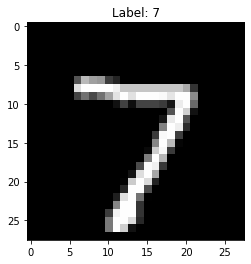

In [137]:
_, predicted = torch.max(model(test_dataset_array[0:1].cuda()), 1)

plt.imshow(test_dataset_array[0].reshape(28,28), cmap = 'gray')
plt.title(f"Label: {predicted.item()}")
plt.show()